In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ----------- ---------------------------- 3.1/11.1 MB 17.9 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 18.9 MB/s eta 0:00:01
   ------------------------------------ --- 10.2/11.1 MB 17.2 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 16.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import zipfile # Used for working with ZIP files (e.g., extracting dataset archives)
import os # Provides functions for interacting with the operating system (e.g., file paths, directories)
from glob import glob # Lets you search for file patterns using wildcards (e.g., *.png)
from tqdm import tqdm # Adds a progress bar to loops for visual feedback during long operations
import shutil # Allows copying and moving files and directories
from PIL import Image # Python Imaging Library for opening, manipulating, and saving images
from sklearn.model_selection import train_test_split  # Used to split datasets into training and testing sets
import torch  # Core PyTorch library for building and training neural networks
import torch.nn as nn # Provides classes for building neural network layers
import torch.nn.functional as F # Contains functions like activation functions (ReLU, softmax, etc.)
from torchvision import datasets, transforms, models # torchvision tools for image data, preprocessing, and pre-trained models
from torch.utils.data import DataLoader  # Utility for batching and loading datasets during training

In [ ]:
# Paths to ZIP files
# breakhis_zip = "./BreakHis - Breast Cancer Histopathological Database.zip"
# idc_zip = "./archive (1).zip"

# # Extract ZIPs
# with zipfile.ZipFile(breakhis_zip, 'r') as zip_ref:
#     zip_ref.extractall("/content/BreaKHis")
# with zipfile.ZipFile(idc_zip, 'r') as zip_ref:
#     zip_ref.extractall("/content/IDC")

In [ ]:
# Check if nested ZIP exists in BreaKHis
# nested_zip_path = "/content/BreaKHis/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1.zip"
# extract_path = "/content/BreaKHis/Extracted"
# if not os.path.exists(extract_path):
#     os.makedirs(extract_path)
# with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# # Merge IDC and BreaKHis into Unified_Dataset (benign/malignant)
# output_root = "/content/Unified_Dataset"
# for cls in ["benign", "malignant"]:
#     os.makedirs(f"{output_root}/{cls}", exist_ok=True)

In [ ]:
# # Copy IDC images
# print("Copying IDC images...")
# for label in ['0', '1']:
#     class_name = "benign" if label == '0' else "malignant"
#     image_paths = glob(f"/content/IDC/**/{label}/*.png", recursive=True)
#     for img_path in tqdm(image_paths, desc=f"IDC → {class_name}"):
#         try:
#             filename = os.path.basename(img_path)
#             shutil.copy(img_path, f"{output_root}/{class_name}/{label}_IDC_{filename}")
#         except:
#             pass

# # Copy BreaKHis images
# print("Copying BreaKHis images...")
# for class_name in ["benign", "malignant"]:
#     image_paths = glob(f"{extract_path}/{class_name}/**/*.png", recursive=True)
#     for img_path in tqdm(image_paths, desc=f"BreaKHis → {class_name}"):
#         try:
#             filename = os.path.basename(img_path)
#             shutil.copy(img_path, f"{output_root}/{class_name}/BreaKHis_{filename}")
#         except:
#             pass

# # Resize, normalize, and split dataset into train/val/test
# output_dir = "/content/Preprocessed"
# img_size = (224, 224)
# for split in ['train', 'val', 'test']:
#     for cls in ['benign', 'malignant']:
#         os.makedirs(f"{output_dir}/{split}/{cls}", exist_ok=True)

# def preprocess_and_split(class_name):
#     image_paths = glob(f"{output_root}/{class_name}/*.png")
#     train, test = train_test_split(image_paths, test_size=0.2, random_state=42)
#     train, val = train_test_split(train, test_size=0.1, random_state=42)
#     for split, paths in zip(['train', 'val', 'test'], [train, val, test]):
#         for img_path in tqdm(paths, desc=f"{class_name} → {split}"):
#             try:
#                 img = Image.open(img_path).convert('RGB')
#                 img = img.resize(img_size)
#                 img.save(f"{output_dir}/{split}/{class_name}/{os.path.basename(img_path)}")
#             except:
#                 continue

# preprocess_and_split("benign")
# preprocess_and_split("malignant")
# print("Preprocessing complete.")

# Prepare DataLoaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert image to PyTorch tensor (shape: [C, H, W], values: [0, 1])
    transforms.Normalize([0.5], [0.5])      # Normalize with mean=0.5 and std=0.5 (scales input to [-1, 1])
])
batch_size = 32
train_loader = DataLoader(datasets.ImageFolder(f"{output_dir}/train", transform=transform), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(datasets.ImageFolder(f"{output_dir}/val", transform=transform), batch_size=batch_size)
test_loader  = DataLoader(datasets.ImageFolder(f"{output_dir}/test", transform=transform), batch_size=batch_size)

# Define BreastNet model with channel attention
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1) # Reduce spatial dimensions to 1x1
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1)  # Shrink channels
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1)  # Expand channels back
        self.sigmoid = nn.Sigmoid()     # Output weights between 0 and 1

    def forward(self, x):
        out = self.pool(x)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return x * out          # Reweight original features

class BreastNet(nn.Module):
    def __init__(self):
        super(BreastNet, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Conv layer: 3 input channels → 32 output
        self.bn = nn.BatchNorm2d(32)                # Normalize feature maps
        self.attn = ChannelAttention(32)            # Learn which channels to emphasize
        self.pool = nn.AdaptiveAvgPool2d((8, 8))    # Reduce to 8x8 spatial size
        self.fc = nn.Linear(32 * 8 * 8, 2)          # Final layer → 2 output classes

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))   # Conv → BN → ReLU
        x = self.attn(x)        # Apply channel attention
        x = self.pool(x)        # Downsample
        x = x.view(x.size(0), -1)   # Flatten for linear layer
        return self.fc(x)       # Final prediction



In [ ]:
import os # For file and folder operations (e.g., creating directories, joining paths, checking existence).
import shutil # For high-level file operations, like copying files.
from glob import glob # For finding file paths that match a specified pattern (e.g., all .png files in a directory).
from PIL import Image # From the Pillow library, used for opening, manipulating (like resizing), and saving image files.
from tqdm import tqdm # For displaying smart progress bars, making loops visually trackable.
from sklearn.model_selection import train_test_split # From scikit-learn, used for splitting datasets into random train and test (or train/val/test) subsets.

import torch # Imports the PyTorch deep learning framework. (Although not directly used in this script, it's common in a larger project context).
from torch.utils.data import DataLoader # Imports DataLoader (not directly used in this script, but typically used with PyTorch datasets).
from torchvision import transforms, datasets # Imports transforms and datasets from torchvision (not directly used in this script, but related to data handling).

# Adjust these paths to your system
idc_root = r"D:\extra\BC\archive (1)" # Defines the root directory for the IDC (Invasive Ductal Carcinoma) dataset. The 'r' prefix makes it a raw string, useful for Windows paths.
# breakhis_root = r"D:\extra\BC\dataset_cancer_v1\classification_binaria" # This line is commented out, but it would define the root directory for the BreaKHis dataset.
output_root = r"D:\extra\BC\merged_data" # Defines the root directory where images from both datasets will be copied and merged.

# Create output directories
os.makedirs(f"{output_root}/benign", exist_ok=True) # Creates the 'benign' subfolder within 'output_root'. 'exist_ok=True' prevents an error if the directory already exists.
os.makedirs(f"{output_root}/malignant", exist_ok=True) # Creates the 'malignant' subfolder within 'output_root'.

### --- Copy IDC Images --- ###
print("Copying IDC images...") # Prints a message indicating the start of copying IDC images.
for folder in glob(os.path.join(idc_root, "*")): # Loops over all immediate subfolders within the 'idc_root' directory. These subfolders typically represent patient IDs.
    for label in ['0', '1']: # Loops over the two class labels: '0' (benign) and '1' (malignant).
        class_name = "benign" if label == '0' else "malignant" # Assigns a human-readable class name based on the label ('0' -> "benign", '1' -> "malignant").
        label_folder = os.path.join(folder, label) # Constructs the full path to the class-specific subfolder within the current patient's folder (e.g., 'patientID/0' or 'patientID/1').
        if os.path.isdir(label_folder): # Checks if the constructed 'label_folder' actually exists and is a directory.
            image_paths = glob(os.path.join(label_folder, "*.png")) # Finds all PNG image files within the current 'label_folder'.
            for img_path in tqdm(image_paths, desc=f"IDC → {class_name}"): # Iterates through each image path with a progress bar.
                try: # Starts a try-except block to handle potential errors during file operations.
                    filename = os.path.basename(img_path) # Extracts just the filename (e.g., 'image.png') from the full path.
                    # Copies the image to the 'output_root' under the respective 'benign' or 'malignant' subfolder.
                    # It renames the file by adding an "IDC_" prefix and the numerical label (0 or 1) for clarity and to prevent name clashes.
                    shutil.copy(img_path, f"{output_root}/{class_name}/IDC_{label}_{filename}") 
                except: # Catches any exception that occurs during the copy operation.
                    continue # Skips to the next image if an error occurs, preventing the script from crashing.

#--- Copy BreaKHis Images --- #
print("Copying BreaKHis images...") # Prints a message indicating the start of copying BreaKHis images.
# NOTE: The `breakhis_root` variable is commented out in the CONFIG section. This part of the code will cause an error
# because `breakhis_root` is not defined. You would need to uncomment and define `breakhis_root` for this section to run.
for magnification in ["40X", "100X", "200X", "400X"]: # Loops through different magnification levels of the BreaKHis dataset.
    for class_name in ["benign", "malignant"]: # Loops through the class names.
        # Constructs the path to images for a specific magnification and class.
        image_paths = glob(os.path.join(breakhis_root, magnification, class_name, "*.png"))
        for img_path in tqdm(image_paths, desc=f"BreaKHis {magnification} → {class_name}"): # Iterates through images with a progress bar.
            try: # Starts a try-except block.
                filename = os.path.basename(img_path) # Extracts the filename.
                new_name = f"BreaKHis_{magnification}_{filename}" # Creates a new filename with a "BreaKHis_" prefix and magnification level.
                # Copies the image to the 'output_root' under the respective class subfolder with the new name.
                shutil.copy(img_path, f"{output_root}/{class_name}/{new_name}")
            except: # Catches any exception.
                continue # Skips to the next image.

### --- Resize and Split Dataset --- ###
output_dir = r"../Preprocessed_breakhis" # Defines the output directory for the resized and split dataset. This path is relative to the current script's location.
img_size = (224, 224) # Defines the target image size (width, height) for resizing.

# Create output folders for the resized and split dataset
for split in ['train', 'val', 'test']: # Loops through dataset splits.
    for cls in ['benign', 'malignant']: # Loops through class names.
        # Creates the nested directory structure (e.g., '../Preprocessed_breakhis/train/benign').
        os.makedirs(f"{output_dir}/{split}/{cls}", exist_ok=True)

def preprocess_and_split(class_name): # Defines a function to take images from the merged 'output_root', resize them, and split them into train/val/test.
    image_paths = glob(f"{output_root}/{class_name}/*.png") # Finds all PNG images for the given 'class_name' in the merged 'output_root'.
    # Splits the image paths into training (80%), test (20%).
    train, test = train_test_split(image_paths, test_size=0.2, random_state=42)
    # Further splits the 'train' set into actual training (90% of the 80%) and validation (10% of the 80%).
    train, val = train_test_split(train, test_size=0.1, random_state=42)
    
    for split, paths in zip(['train', 'val', 'test'], [train, val, test]): # Loops through the three splits and their respective image paths.
        for img_path in tqdm(paths, desc=f"{class_name} → {split}"): # Iterates through each image path with a progress bar.
            try: # Starts a try-except block.
                img = Image.open(img_path).convert('RGB') # Opens the image and ensures it's in RGB format.
                img = img.resize(img_size) # Resizes the image to the predefined `img_size`.
                # Saves the resized image to the appropriate split and class subfolder within the `output_dir`.
                # `os.path.basename(img_path)` gets just the filename (e.g., 'IDC_0_image.png' or 'BreaKHis_40X_image.png').
                img.save(f"{output_dir}/{split}/{class_name}/{os.path.basename(img_path)}")
            except: # Catches any exception during image processing or saving.
                continue # Skips to the next image if an error occurs.

preprocess_and_split("benign") # Calls the preprocessing and splitting function for "benign" images.
preprocess_and_split("malignant") # Calls the preprocessing and splitting function for "malignant" images.

print("✅ Preprocessing complete.") # Prints a final message indicating the completion of all preprocessing tasks.

Copying IDC images...


IDC → malignant: 100%|██████████| 70/70 [00:00<00:00, 135.64it/s]


Copying BreaKHis images...


BreaKHis 40X → benign: 0it [00:00, ?it/s]
BreaKHis 40X → malignant: 0it [00:00, ?it/s]
BreaKHis 100X → benign: 0it [00:00, ?it/s]
BreaKHis 100X → malignant: 0it [00:00, ?it/s]
BreaKHis 200X → benign: 0it [00:00, ?it/s]
BreaKHis 200X → malignant: 0it [00:00, ?it/s]
BreaKHis 400X → benign: 0it [00:00, ?it/s]
BreaKHis 400X → malignant: 0it [00:00, ?it/s]
malignant → test: 100%|██████████| 15758/15758 [07:58<00:00, 32.92it/s]

✅ Preprocessing complete.


In [ ]:
import os # Imports the 'os' module for interacting with the operating system (e.g., path manipulation, directory creation).
from glob import glob # Imports the 'glob' function for finding files matching specific patterns.
from PIL import Image # Imports the 'Image' module from the Pillow library for image processing.
from tqdm import tqdm # Imports 'tqdm' for displaying progress bars.
from sklearn.model_selection import train_test_split # Imports 'train_test_split' from scikit-learn for splitting datasets.

# === CONFIG ===
idc_root = r"D:\thisisimp\paper 2024\archive_extracted" # Defines the root directory of the IDC (Invasive Ductal Carcinoma) dataset.
output_dir = r"D:\thisisimp\working-bc\Preprocessed_breakhis" # Defines the output directory where preprocessed images will be saved. The comment suggests this is an existing folder for BreakHis data, implying IDC data will be merged into it.
img_size = (224, 224) # Defines the target size for resizing images.

# === PREPROCESS FUNCTION ===
def preprocess_and_split(class_name, label_folder): # Defines a function to preprocess and split images for a given class.
    print(f"\n📂 Processing {class_name} images in {label_folder}") # Prints a message indicating which class and folder are being processed.
    image_paths = glob(os.path.join(label_folder, "*.png")) # Finds all .png image files within the specified 'label_folder'.

    # Split dataset: The images from the current `label_folder` are split into train, test, and validation sets.
    # First, split into training (80%) and test (20%).
    train, test = train_test_split(image_paths, test_size=0.2, random_state=42)
    # Then, split the 'train' portion further into actual training (90% of the 80%, so 72% overall) and validation (10% of the 80%, so 8% overall).
    train, val = train_test_split(train, test_size=0.1, random_state=42)

    # Loop through each split (train, val, test) and their respective image paths.
    for split, paths in zip(['train', 'val', 'test'], [train, val, test]):
        # Iterate through each image path in the current split with a progress bar.
        for img_path in tqdm(paths, desc=f"IDC {class_name} → {split}"):
            try: # Use a try-except block to handle potential errors during image processing.
                img = Image.open(img_path).convert('RGB') # Opens the image and converts it to RGB format (ensures 3 channels).
                img = img.resize(img_size) # Resizes the image to the specified `img_size` (224x224).

                # Creates the destination directory if it doesn't exist.
                # This ensures `output_dir/split/class_name` (e.g., Preprocessed_breakhis/train/benign) exists before saving.
                os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)
                
                # Constructs a new filename to avoid conflicts and provide more context.
                # It prefixes "IDC_" and the class name to the original filename.
                filename = f"IDC_{class_name}_{os.path.basename(img_path)}"
                # Constructs the full destination path for the processed image.
                dest_path = os.path.join(output_dir, split, class_name, filename)
                img.save(dest_path) # Saves the processed image to the destination path.
            except Exception as e: # Catches any exception that occurs during image opening, resizing, or saving.
                print(f"⚠️ Error with {img_path}: {e}") # Prints an error message.

# === RUN FOR EACH FOLDER IN IDC ROOT ===
print("🔍 Scanning IDC folders...\n") # Prints a message indicating the start of scanning IDC folders.
# Iterates through each subfolder directly within the `idc_root` directory. These are typically patient ID folders.
for folder in glob(os.path.join(idc_root, "*")):
    # For each patient folder, iterate through the two possible label subfolders ('0' for benign, '1' for malignant).
    for label in ['0', '1']:
        class_name = "benign" if label == '0' else "malignant" # Determines the class name ("benign" or "malignant") based on the label.
        label_folder = os.path.join(folder, label) # Constructs the full path to the specific label folder within the current patient's directory.
        if os.path.isdir(label_folder): # Checks if the `label_folder` actually exists and is a directory.
            preprocess_and_split(class_name, label_folder) # Calls the preprocessing function for the detected class and its folder.

print("\n IDC images added to BreakHis preprocessed folder.") # Prints a final message indicating completion.

In [ ]:
import os # Imports the 'os' module for interacting with the operating system, like checking paths and listing directories.
from glob import glob # Imports the 'glob' function from the 'glob' module, used for finding files matching a specific pattern.

idc_root = r"D:\thisisimp\paper 2024\archive_extracted" # Defines the root directory path where the IDC (Invasive Ductal Carcinoma) image dataset is expected to be located. The 'r' prefix makes it a raw string, useful for Windows paths.

if not os.path.exists(idc_root): # Checks if the specified root directory exists.
    print(f"❌ The folder does not exist: {idc_root}") # If the folder does not exist, prints an error message.
else:
    print(f"📁 Found root folder: {idc_root}\n") # If the folder exists, prints a confirmation message.

    # Scans the 'idc_root' directory and creates a list of paths to its immediate subfolders.
    # This assumes each subfolder represents a patient ID.
    subfolders = [f.path for f in os.scandir(idc_root) if f.is_dir()]
    print(f"🔍 Found {len(subfolders)} patient folders.\n") # Prints the number of patient subfolders found.

    total_benign = 0 # Initializes a counter for the total number of benign images across all patients.
    total_malignant = 0 # Initializes a counter for the total number of malignant images across all patients.

    for subfolder in subfolders: # Iterates through each patient subfolder.
        benign_path = os.path.join(subfolder, "0") # Constructs the path to the '0' subfolder, which typically contains benign images.
        malignant_path = os.path.join(subfolder, "1") # Constructs the path to the '1' subfolder, which typically contains malignant images.

        # Counts the number of .png files in the 'benign_path' if the path exists, otherwise sets count to 0.
        benign_count = len(glob(os.path.join(benign_path, "*.png"))) if os.path.exists(benign_path) else 0
        # Counts the number of .png files in the 'malignant_path' if the path exists, otherwise sets count to 0.
        malignant_count = len(glob(os.path.join(malignant_path, "*.png"))) if os.path.exists(malignant_path) else 0

        total_benign += benign_count # Adds the current patient's benign count to the overall total.
        total_malignant += malignant_count # Adds the current patient's malignant count to the overall total.

        # Prints the image counts for the current patient subfolder.
        print(f"📦 {os.path.basename(subfolder)}: " 
              f"{benign_count} benign, {malignant_count} malignant")

    print("\n✅ Summary:") # Prints a header for the summary.
    print(f"Total benign images: {total_benign}") # Prints the grand total of benign images.
    print(f"Total malignant images: {total_malignant}") # Prints the grand total of malignant images.

📁 Found root folder: D:\thisisimp\paper 2024\archive_extracted

🔍 Found 280 patient folders.

📦 10253: 479 benign, 70 malignant
📦 10254: 772 benign, 76 malignant
📦 10255: 181 benign, 91 malignant
📦 10256: 351 benign, 117 malignant
📦 10257: 427 benign, 208 malignant
📦 10258: 422 benign, 108 malignant
📦 10259: 1434 benign, 31 malignant
📦 10260: 928 benign, 361 malignant
📦 10261: 590 benign, 56 malignant
📦 10262: 1053 benign, 754 malignant
📦 10264: 617 benign, 587 malignant
📦 10268: 2086 benign, 23 malignant
📦 10269: 904 benign, 250 malignant
📦 10272: 2150 benign, 25 malignant
📦 10273: 811 benign, 1211 malignant
📦 10274: 659 benign, 219 malignant
📦 10275: 297 benign, 760 malignant
📦 10276: 591 benign, 348 malignant
📦 10277: 785 benign, 170 malignant
📦 10278: 1068 benign, 91 malignant
📦 10279: 1267 benign, 427 malignant
📦 10282: 1835 benign, 198 malignant
📦 10285: 1011 benign, 222 malignant
📦 10286: 458 benign, 162 malignant
📦 10288: 2231 benign, 47 malignant
📦 10290: 1891 benign, 140 mali

In [ ]:
import os
import shutil
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ==== CONFIGURATION ====
breakhis_root = r"D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria"
merged_output = r".\merged_data_breakhis"
final_output = r".\Preprocessed_breakhis"
magnifications = ["40X", "100X", "200X", "400X"]
classes = ["benign", "malignant"]
img_size = (224, 224)
split_ratios = {'test': 0.2, 'val': 0.1}

# ==== CREATE OUTPUT FOLDERS ====
for cls in classes:
    os.makedirs(os.path.join(merged_output, cls), exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(final_output, split, cls), exist_ok=True)

# ==== CHECK FOLDER STRUCTURE ====
print("\n🔍 Validating BreakHis directory structure...\n")
all_ok = True
for mag in magnifications:
    for cls in classes:
        folder_path = os.path.join(breakhis_root, mag, cls)
        if not os.path.exists(folder_path):
            print(f"❌ Missing: {folder_path}")
            all_ok = False
        else:
            count = len(glob(os.path.join(folder_path, "*.png")))
            print(f"✅ Found {count} images in {folder_path}")

if not all_ok:
    raise RuntimeError("❗ Dataset structure is incomplete. Aborting.")

# ==== COPY IMAGES ====
print("\n📥 Copying BreakHis images...\n")
for mag in magnifications:
    for cls in classes:
        src_dir = os.path.join(breakhis_root, mag, cls)
        images = glob(os.path.join(src_dir, "*.png"))
        for img_path in tqdm(images, desc=f"{mag} → {cls}"):
            try:
                filename = os.path.basename(img_path)
                new_name = f"BreaKHis_{mag}_{filename}"
                dst_path = os.path.join(merged_output, cls, new_name)
                shutil.copy(img_path, dst_path)
            except Exception as e:
                print(f"⚠️ Error copying {img_path}: {e}")

# ==== PREPROCESS + SPLIT ====
def preprocess_and_split(class_name):
    print(f"\n📦 Processing class: {class_name}")
    images = glob(os.path.join(merged_output, class_name, "*.png"))

    # Split
    train_imgs, test_imgs = train_test_split(images, test_size=split_ratios['test'], random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=split_ratios['val'], random_state=42)

    # Organize
    for split, img_list in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        for img_path in tqdm(img_list, desc=f"{class_name} → {split}"):
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(img_size)
                dest_path = os.path.join(final_output, split, class_name, os.path.basename(img_path))
                img.save(dest_path)
            except Exception as e:
                print(f"⚠️ Error processing {img_path}: {e}")

# Run preprocessing
for cls in classes:
    preprocess_and_split(cls)

print("\n✅ BreakHis preprocessing complete.")



🔍 Validating BreakHis directory structure...

✅ Found 625 images in D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\40X\benign
✅ Found 1370 images in D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\40X\malignant
✅ Found 644 images in D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\100X\benign
✅ Found 1437 images in D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\100X\malignant
✅ Found 623 images in D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\200X\benign
✅ Found 1390 images in D:\thisisimp\paper 2024\BreakHis\BreakH

400X → malignant: 100%|██████████| 1232/1232 [00:17<00:00, 72.39it/s]



📦 Processing class: benign


benign → test: 100%|██████████| 496/496 [00:14<00:00, 33.19it/s]



📦 Processing class: malignant


malignant → test: 100%|██████████| 1086/1086 [00:33<00:00, 32.58it/s]


✅ BreakHis preprocessing complete.


In [ ]:
import os
from glob import glob

# Set your root path
breakhis_root = r"D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria"

# Define expected structure
magnifications = ["40X", "100X", "200X", "400X"]
classes = ["benign", "malignant"]

all_ok = True  # flag to track overall status

print("🔍 Validating BreakHis directory structure...\n")

for mag in magnifications:
    mag_path = os.path.join(breakhis_root, mag)
    if not os.path.exists(mag_path):
        print(f"❌ Missing magnification folder: {mag_path}")
        all_ok = False
        continue

    for cls in classes:
        class_path = os.path.join(mag_path, cls)
        if not os.path.exists(class_path):
            print(f"❌ Missing class folder: {class_path}")
            all_ok = False
            continue

        # Check if folder has image files
        images = glob(os.path.join(class_path, "*.png"))
        if len(images) == 0:
            print(f"⚠️ No PNG images found in: {class_path}")
        else:
            print(f"✅ Found {len(images)} images in: {class_path}")

if all_ok:
    print("\n🎉 All expected folders are present.")
else:
    print("\n🚫 Some folders are missing. Please check paths.")


🔍 Validating BreakHis directory structure...

✅ Found 625 images in: D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\40X\benign
✅ Found 1370 images in: D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\40X\malignant
✅ Found 644 images in: D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\100X\benign
✅ Found 1437 images in: D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\100X\malignant
✅ Found 623 images in: D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria\200X\benign
✅ Found 1390 images in: D:\thisisimp\paper 2024\BreakHis\B

In [ ]:
# import os
# import shutil
# from glob import glob
# from PIL import Image
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split

# # === PATH CONFIGURATION ===
# idc_root = r"D:\thisisimp\paper 2024\archive_extracted"  # IDC source
# output_root = r"D:\thisisimp\working-bc\merged_data_breakhis"                 # Merge target (already used by BreakHis)
# output_dir = r"D:\thisisimp\working-bc\Preprocessed_breakhis"                 # Preprocessed BreakHis directory
# img_size = (224, 224)

# # === Ensure merge folders exist ===
# os.makedirs(os.path.join(output_root, "benign"), exist_ok=True)
# os.makedirs(os.path.join(output_root, "malignant"), exist_ok=True)

# # === STEP 1: Merge IDC images ===
# print("\n🔄 Merging IDC images into:", output_root)

# for folder in glob(os.path.join(idc_root, "*")):
#     for label in ['0', '1']:
#         class_name = "benign" if label == '0' else "malignant"
#         label_folder = os.path.join(folder, label)
#         if os.path.isdir(label_folder):
#             image_paths = glob(os.path.join(label_folder, "*.png"))
#             for img_path in tqdm(image_paths, desc=f"IDC → {class_name}"):
#                 try:
#                     filename = os.path.basename(img_path)
#                     new_name = f"IDC_{label}_{filename}"
#                     dest = os.path.join(output_root, class_name, new_name)
#                     shutil.copy(img_path, dest)
#                 except Exception as e:
#                     print(f"⚠️ Error copying {img_path}: {e}")

# # === STEP 2: Preprocess and append to existing BreakHis splits ===
# print("\n🧪 Preprocessing and adding IDC images to BreakHis train/val/test folders...")

# def preprocess_and_split(class_name):
#     image_paths = glob(os.path.join(output_root, class_name, "*.png"))
#     if not image_paths:
#         print(f"⚠️ No images found in: {os.path.join(output_root, class_name)}")
#         return

#     train, test = train_test_split(image_paths, test_size=0.2, random_state=42)
#     train, val = train_test_split(train, test_size=0.1, random_state=42)

#     for split, paths in zip(['train', 'val', 'test'], [train, val, test]):
#         for img_path in tqdm(paths, desc=f"{class_name} → {split}"):
#             try:
#                 img = Image.open(img_path).convert('RGB')
#                 img = img.resize(img_size)
#                 filename = os.path.basename(img_path)
#                 save_path = os.path.join(output_dir, split, class_name, filename)
#                 img.save(save_path)
#             except Exception as e:
#                 print(f"⚠️ Error processing {img_path}: {e}")

# preprocess_and_split("benign")
# preprocess_and_split("malignant")

# print("\n✅ Done! IDC images are now merged and preprocessed into BreakHis dataset.")



🔄 Merging IDC images into: D:\thisisimp\working-bc\merged_data_breakhis


IDC → benign:   3%|▎         | 11/427 [00:00<00:06, 64.21it/s]


KeyboardInterrupt: 

In [ ]:
# # Initialize model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BreastNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import torch.nn.functional as F
# import torch.nn as nn
# import torch

# # Paths and Device
# data_root = r"D:\extra\BC\Preprocessed"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
# ])

# # Loaders
# batch_size = 32
# train_loader = DataLoader(datasets.ImageFolder(f"{data_root}/train", transform=transform), batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(datasets.ImageFolder(f"{data_root}/val", transform=transform), batch_size=batch_size, shuffle=False)
# test_loader  = DataLoader(datasets.ImageFolder(f"{data_root}/test", transform=transform), batch_size=batch_size, shuffle=False)

# # Define the model (assumes BreastNet from earlier)
# model = BreastNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Training Loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     total, correct, running_loss = 0, 0, 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     train_acc = 100 * correct / total
#     train_loss = running_loss / len(train_loader)

#     # Validation Step
#     model.eval()
#     val_total, val_correct, val_loss = 0, 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()

#     val_acc = 100 * val_correct / val_total
#     val_loss = val_loss / len(val_loader)

#     print(f"Epoch {epoch+1}/{num_epochs} | "
#           f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
#           f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

# print("✅ Training Complete.")


In [ ]:
# # Import required libraries
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, random_split
# import matplotlib.pyplot as plt
# import os

# # Define Channel Attention block
# class ChannelAttention(nn.Module):
#     def __init__(self, in_planes, ratio=8):
#         super(ChannelAttention, self).__init__()
#         self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1, bias=False)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         out = self.global_avg_pool(x)
#         out = self.fc1(out)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return x * self.sigmoid(out)

# # Define BreastNet model
# class BreastNet(nn.Module):
#     def __init__(self):
#         super(BreastNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.ca1 = ChannelAttention(32)
#         self.pool = nn.AdaptiveAvgPool2d((8, 8))
#         self.fc1 = nn.Linear(32 * 8 * 8, 2)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.ca1(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         return x

# # Set device for training
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Image preprocessing
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
# ])

# # Load dataset from directory structure
# source_path = "/content/Preprocessed/train"
# dataset = datasets.ImageFolder(root=source_path, transform=transform)

# # Split into 80% train and 20% validation
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Initialize model, loss function, optimizer
# model = BreastNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Train model
# num_epochs = 10
# train_losses, val_losses = [], []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss, correct_train, total_train = 0, 0, 0

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()

#     train_losses.append(train_loss / len(train_loader))
#     train_acc = 100 * correct_train / total_train

#     model.eval()
#     val_loss, correct_val, total_val = 0, 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total_val += labels.size(0)
#             correct_val += (predicted == labels).sum().item()

#     val_losses.append(val_loss / len(val_loader))
#     val_acc = 100 * correct_val / total_val

#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_losses[-1]:.4f}, Acc: {val_acc:.2f}%")

# # Plot loss curves
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training vs Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Save model
# model_path = "breastnet_model.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model saved as {model_path}")


In [ ]:
# #import os
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import torch.nn.functional as F
# import torch.nn as nn
# import torch

# # Set paths and device
# data_root = r"D:\extra\BC\Preprocessed"
# model_dir = "./models"
# os.makedirs(model_dir, exist_ok=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"[INFO] Using device: {device}")

# # Transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
# ])

# # Loaders
# batch_size = 32
# print("[INFO] Loading datasets...")
# train_loader = DataLoader(datasets.ImageFolder(f"{data_root}/train", transform=transform), batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(datasets.ImageFolder(f"{data_root}/val", transform=transform), batch_size=batch_size, shuffle=False)
# test_loader  = DataLoader(datasets.ImageFolder(f"{data_root}/test", transform=transform), batch_size=batch_size, shuffle=False)
# print("[INFO] Datasets loaded successfully.")

# # Define BreastNet
# class ChannelAttention(nn.Module):
#     def __init__(self, in_planes, ratio=8):
#         super(ChannelAttention, self).__init__()
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         out = self.pool(x)
#         out = self.relu(self.fc1(out))
#         out = self.sigmoid(self.fc2(out))
#         return x * out

# class BreastNet(nn.Module):
#     def __init__(self):
#         super(BreastNet, self).__init__()
#         self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm2d(32)
#         self.attn = ChannelAttention(32)
#         self.pool = nn.AdaptiveAvgPool2d((8, 8))
#         self.fc = nn.Linear(32 * 8 * 8, 2)

#     def forward(self, x):
#         x = F.relu(self.bn(self.conv(x)))
#         x = self.attn(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)

# # Initialize model
# model = BreastNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Training Loop
# num_epochs = 10
# print("[INFO] Starting training...")
# for epoch in range(num_epochs):
#     print(f"\n[Epoch {epoch+1}/{num_epochs}]")
#     model.train()
#     total, correct, running_loss = 0, 0, 0

#     for batch_idx, (images, labels) in enumerate(train_loader):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
#             print(f"  [Batch {batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

#     train_acc = 100 * correct / total
#     train_loss = running_loss / len(train_loader)

#     # Validation
#     model.eval()
#     val_total, val_correct, val_loss = 0, 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()

#     val_acc = 100 * val_correct / val_total
#     val_loss = val_loss / len(val_loader)

#     print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

#     # Save checkpoint
#     checkpoint_path = os.path.join(model_dir, f"breastnet_epoch{epoch+1}.pth")
#     torch.save({
#         'epoch': epoch + 1,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'train_loss': train_loss,
#         'val_loss': val_loss,
#         'val_accuracy': val_acc
#     }, checkpoint_path)
#     print(f"[INFO] Model checkpoint saved at {checkpoint_path}")

# print("✅ Training Complete.")


[INFO] Using device: cuda
[INFO] Loading datasets...
[INFO] Datasets loaded successfully.
[INFO] Starting training...

[Epoch 1/10]
  [Batch 10/6245] Loss: 0.1573
  [Batch 20/6245] Loss: 0.3558
  [Batch 30/6245] Loss: 0.3544
  [Batch 40/6245] Loss: 0.3608
  [Batch 50/6245] Loss: 0.5345
  [Batch 60/6245] Loss: 0.3699
  [Batch 70/6245] Loss: 0.3732
  [Batch 80/6245] Loss: 0.2773
  [Batch 90/6245] Loss: 0.3546
  [Batch 100/6245] Loss: 0.4487
  [Batch 110/6245] Loss: 0.2303
  [Batch 120/6245] Loss: 0.3035
  [Batch 130/6245] Loss: 0.3860
  [Batch 140/6245] Loss: 0.3410
  [Batch 150/6245] Loss: 0.2580
  [Batch 160/6245] Loss: 0.4476
  [Batch 170/6245] Loss: 0.3763
  [Batch 180/6245] Loss: 0.5279
  [Batch 190/6245] Loss: 0.3042
  [Batch 200/6245] Loss: 0.3583
  [Batch 210/6245] Loss: 0.3812
  [Batch 220/6245] Loss: 0.2765
  [Batch 230/6245] Loss: 0.3992
  [Batch 240/6245] Loss: 0.7122
  [Batch 250/6245] Loss: 0.2818
  [Batch 260/6245] Loss: 0.3970
  [Batch 270/6245] Loss: 0.3962
  [Batch 280/

ONE MORE EXPER

In [3]:
# breastnet_train_fast.py
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
import json

# === Config ===
data_dir = r"D:\\thisisimp\\working-bc\\Preprocessed"
breastnet_output_dir = r"D:\\thisisimp\\working-bc\\breastnet"
os.makedirs(breastnet_output_dir, exist_ok=True)
train_path = os.path.join(data_dir, "train")
val_path = os.path.join(data_dir, "val")
log_file = os.path.join(breastnet_output_dir, "breastnet_accuracy_log_fast_5epoch.json")
model_save_path = os.path.join(breastnet_output_dir, "breastnet_best_model_fast_5epoch.pth")

batch_size = 32
lr = 1e-3
epochs = 5
sample_fraction = 0.8  # use 80% of train data each epoch
resize_dim = 192

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Transforms (light augmentations for speed) ===
transform = transforms.Compose([
    transforms.Resize((resize_dim, resize_dim)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Dataset ===
train_full = ImageFolder(train_path, transform=transform)
val_ds = ImageFolder(val_path, transform=transform)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# === Channel Attention Block ===
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.pool(x)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return x * out

# === BreastNet ===
class BreastNet(nn.Module):
    def __init__(self):
        super(BreastNet, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.attn = ChannelAttention(32)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        self.fc = nn.Linear(32 * 8 * 8, 2)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.attn(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# === Training ===
model = BreastNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
best_acc = 0
log_data = {}

if os.path.exists(log_file):
    with open(log_file, 'r') as f:
        log_data = json.load(f)
    print("[INFO] Resuming training from previous state...")

start_epoch = len(log_data)

for epoch in range(start_epoch, epochs):
    # === Use 80% random subset of training data each epoch ===
    indices = random.sample(range(len(train_full)), int(sample_fraction * len(train_full)))
    train_subset = Subset(train_full, indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)

    model.train()
    running_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # === Validation ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy after epoch {epoch+1}: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), model_save_path)
        print("[INFO] Best model saved.")

    log_data[str(epoch+1)] = {"val_accuracy": acc}
    with open(log_file, 'w') as f:
        json.dump(log_data, f, indent=2)

print("Final Best Accuracy:", best_acc)



Using device: cpu


Epoch 1/5: 100%|██████████| 5138/5138 [2:27:13<00:00,  1.72s/it]  


Validation Accuracy after epoch 1: 0.8469
[INFO] Best model saved.


Epoch 2/5: 100%|██████████| 5138/5138 [2:52:18<00:00,  2.01s/it]  


Validation Accuracy after epoch 2: 0.8569
[INFO] Best model saved.


Epoch 3/5: 100%|██████████| 5138/5138 [2:13:28<00:00,  1.56s/it]  


Validation Accuracy after epoch 3: 0.8604
[INFO] Best model saved.


Epoch 4/5: 100%|██████████| 5138/5138 [2:18:49<00:00,  1.62s/it]  


Validation Accuracy after epoch 4: 0.8603


Epoch 5/5: 100%|██████████| 5138/5138 [2:14:13<00:00,  1.57s/it]  


Validation Accuracy after epoch 5: 0.8648
[INFO] Best model saved.
Final Best Accuracy: 0.8647749167980382


[INFO] Evaluating BreastNet
[INFO] Evaluating ResNet18
[INFO] Evaluating VGG16


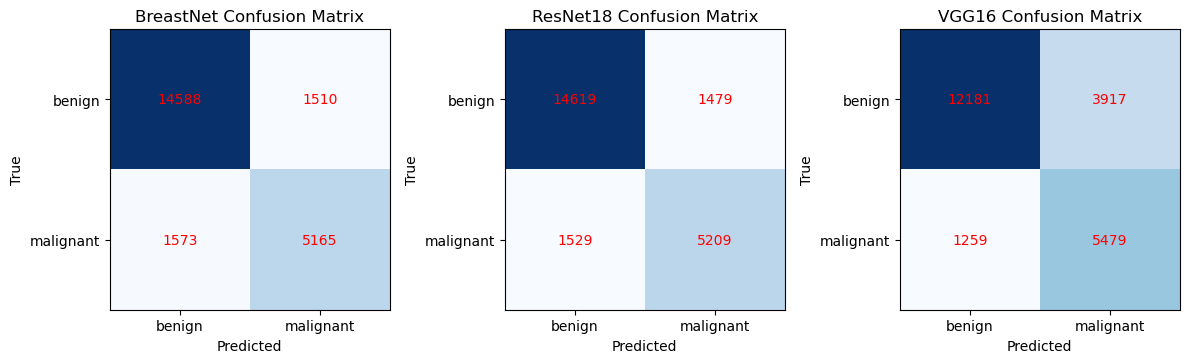

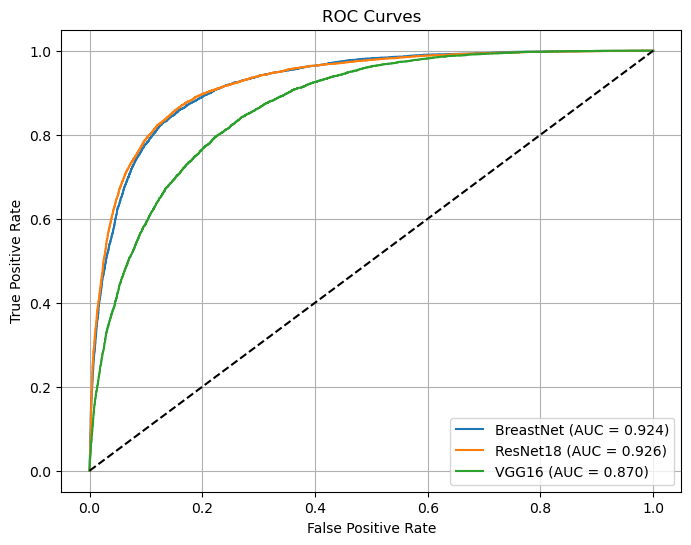

Model        Accuracy   Precision  Recall     F1-Score   AUC       
-----------------------------------------------------------------
BreastNet    0.8650     0.7738     0.7665     0.7701     0.9236    
ResNet18     0.8683     0.7789     0.7731     0.7760     0.9261    
VGG16        0.7733     0.5831     0.8131     0.6792     0.8698    


In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# === Paths ===
val_path = r"D:\thisisimp\working-bc\Preprocessed\val"
model_paths = {
    "BreastNet": r"D:\thisisimp\working-bc\breastnet\breastnet_best_model_fast_5epoch.pth",
    "ResNet18": r"D:\thisisimp\working-bc\resnet18 models\resnet18_epoch5.pth",
    "VGG16": r"D:\thisisimp\working-bc\vgg16 models\vgg16_best.pth"
}

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Dataset ===
val_dataset = ImageFolder(val_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
class_names = val_dataset.classes  # ['benign', 'malignant']

# === Model Definitions ===
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.pool(x)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return x * out

class BreastNet(nn.Module):
    def __init__(self):
        super(BreastNet, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.attn = ChannelAttention(32)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        self.fc = nn.Linear(32 * 8 * 8, 2)

    def forward(self, x):
        x = torch.relu(self.bn(self.conv(x)))
        x = self.attn(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def get_model(name):
    if name == "BreastNet":
        model = BreastNet()
    elif name == "ResNet18":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif name == "VGG16":
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    return model.to(device)

# === Evaluation + Storage ===
results = {}
for name, path in model_paths.items():
    print(f"[INFO] Evaluating {name}")
    model = get_model(name)
    
    checkpoint = torch.load(path, map_location=device)
    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
    else:
        model.load_state_dict(checkpoint)
        
    model.eval()

    all_probs, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Prob of class 1
            preds = outputs.argmax(dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    results[name] = {
        "labels": np.array(all_labels),
        "preds": np.array(all_preds),
        "probs": np.array(all_probs)
    }

# === Confusion Matrices ===
plt.figure(figsize=(12, 4))
for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(res["labels"], res["preds"])
    plt.subplot(1, 3, i + 1)
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], class_names)
    plt.yticks([0, 1], class_names)
    for r in range(2):
        for c in range(2):
            plt.text(c, r, cm[r, c], ha="center", va="center", color="red")
plt.tight_layout()
plt.savefig("confusion_matrix_compare.png")
plt.show()

# === ROC Curves ===
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(res["labels"], res["probs"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.savefig("roc_compare.png")
plt.show()

# === Metrics Table ===
print(f"{'Model':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 65)
for name, res in results.items():
    acc = accuracy_score(res["labels"], res["preds"])
    prec = precision_score(res["labels"], res["preds"])
    rec = recall_score(res["labels"], res["preds"])
    f1 = f1_score(res["labels"], res["preds"])
    roc_auc = auc(*roc_curve(res["labels"], res["probs"])[:2])
    print(f"{name:<12} {acc:<10.4f} {prec:<10.4f} {rec:<10.4f} {f1:<10.4f} {roc_auc:<10.4f}")
